In [138]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib as mpl
import argparse
from read_ggp_run import *
import copy


def mk_missing_dir(directory):
    if not os.path.exists(directory):
        os.mkdir(directory) 
    return directory

def header_lines(filename, until="cell_id"):
    with open(filename,'r') as fin:
        for i, line in enumerate(fin):
            if line.startswith(until):
                return i

def read_final_params(filename):
        parameters_arr = np.genfromtxt(filename, delimiter=',', dtype=str, max_rows=header_lines(filename, until="10")+1)
        param_dict = {}
        for param in parameters_arr[1:]:
            if param[-1] != '':
                param_dict[param[1]] = float(param[-1])
            else:
                param_dict[param[1]] = float(param[3])
        return param_dict

read_final_params(filename)


{'mean_lambda': 0.0226226,
 'gamma_lambda': 0.909958,
 'var_lambda': 9.23738e-05,
 'mean_q': 317.056,
 'gamma_q': 0.161459,
 'var_q': 6258.23,
 'beta': 0.0,
 'var_x': 5.73659e-05,
 'var_g': 3001490.0,
 'var_dx': 0.0182565,
 'var_dg': 26234300.0}

In [162]:

len_mean = 8
len_cov = 36

len_gaussian = len_mean+len_cov


class Cell:
    def __init__(self, cell_id, parent_id):
        self.parent_id = parent_id
        self.cell_id = cell_id

        self.time = []
        self.number_of_joints = []
        self.line = []
        self.joints = []


# ---------------------------------------------------------------------------------------------------------- #
# Classes to go from the input being chunks of len_mean = 8 + len_cov = 36 to the final correlation function
# ---------------------------------------------------------------------------------------------------------- #
class Gaussian:
    ''' 
    Gaussian (8x8)

    Is constructed from the 8+36 chunk of entires from the input file (strings) and saves the mean and the covariance. 
    In case the entries are empty, mean and covariance are set to None

    Attributes:
        m (np.array((8))): Mean
        C (np.array((8,8))): Covariance

    '''
    def __init__(self, vec):
        try:
            self.m = vec[:8].astype(float)
            cov_vec = vec[8:].astype(float)

            sum_i_9 = [36, 35, 33, 30, 26, 21, 15, 8, 0] #  == [np.sum( np.arange(i,9)) for i in np.arange(1,9)[::1]]

            # cov_vec[sum_i_9[i]: sum_i_9[i-1] ] Equivalent to cov_vec[np.sum( np.arange(i+1,9) ): np.sum( np.arange(i,9))]
            # Also the concatenation with 0s is faster than np.pad
            c = np.array( [ np.concatenate( ([0] *(8-i) , cov_vec[sum_i_9[i]: sum_i_9[i-1] ] ) ) for i in np.arange(1,9)[::-1]])

            self.C = c + np.tril(c.T, -1) 
        except:
            self.m = None
            self.C = None


class Correlation:
    '''
    Calculates the correlation of a given dt

    Adds up the means (m) <z_n> as well as the two point means (mm) <z_n, z_m> = <z_n><z_m> + C, 
    while counting the number of joints (n)

    Attributes:
        dt (float): Time lag
        n (int): Number of joints
        m (np.array((8))): Sum of one point means
        V_xy (np.array((8,8))): Sum of two point means
        cov (np.array((8,8))): Covariance matrix (None when initialized)
        corr (np.array((8,8))): Correlation matrix, ie the normalized covariance (None when initialized)

    '''
    def __init__(self, dt = 0):
        self.dt = dt
        self.n = 0

        self.mm = np.zeros((8,8))
        self.m = np.zeros((8))
        
        # Those will be set in average and normalize, resprectively 
        self.cov = None
        self.corr = None

    def add(self, joint):
        self.n += 1
        self.m += joint.m

        self.mm += joint.m * joint.m[:,np.newaxis] + joint.C
        # Equivalent to:
        # for i in range(8): for j in range(8): self.mm[i,j] += joint.m[i] * joint.m[j] + joint.C[i,j]


    def average(self):
        # naive implementation but it is not often run
        self.cov = np.zeros((8,8))
        for i in range(8):
                for j in range(8):
                    self.cov[i,j] = self.mm[i,j]/self.n -  self.m[i]/self.n * self.m[j]/self.n

    def normalize(self):
        # naive implementation but it is not often run
        self.corr = np.zeros((8,8))
        if self.n>0:
            for i in range(8):
                for j in range(8):
                    self.corr[i,j] = self.cov[i,j] / np.sqrt(self.cov[i,i] * self.cov[j,j])



def file2correlation_function(filename, dts, tol, return_isjoint=False, filter_func=lambda a,b,c,d: True): 
    # Variables that will be returned
    correlations = []
    time_points = []
    cell_ids = []
    if return_isjoint:
        is_joint =  np.zeros((0,))

    # initialize a few variable 
    last_cell = ""
    count_cells = 0 
    skip = True
    line_number = 0
    
    correlations = [Correlation(dt=dt) for dt in dts]
    
    with open(filename,'r') as fin:
        for _, line in enumerate(fin):
            if not skip:
                line_splitted = line.strip('\n').split(',')
                cell_id = line_splitted[0]
                time = float(line_splitted[2])
                chunks =  np.reshape(line_splitted[3:], (-1,len_gaussian))
                joints_vecs = [Gaussian(c) if c[0]!='' else None for c in chunks]
                for j, joint in enumerate(joints_vecs):
                    if joint!=None:                        
                        idx = np.argwhere(np.isclose(dts, time_points[j] - time, atol=tol))
                        if len(idx)>0:
                            correlations[idx[0,0]].add(joint)

                        if return_isjoint:
                            is_joint[line_number, j] = 1
                            
                if cell_id != last_cell:
                    print("\rNumber of cells processed: ", count_cells, end='')  
                    count_cells += 1

                last_cell = cell_id
                line_number+=1

            if line.startswith('cell_id'):
                skip = False    
                line_splitted = line.strip('\n').split(',')[3:]
                for entry in line_splitted:
                    if entry != '':
                        cell_ids.append(entry.split('_')[0])
                        time_points.append(float(entry.split('_')[1]))
                if return_isjoint:
                    is_joint = np.zeros((len(time_points), len(time_points)), dtype=int)
    if return_isjoint:
        return correlations, pd.DataFrame(is_joint, columns = cell_ids, index = cell_ids)
    else:
        return correlations


def file2cells(filename, save_joints=False):
    cell_list = []
    time_points = []
    last_cell = ""
    skip = True
    with open(filename,'r') as fin:
        for i, line in enumerate(fin):
            if not skip:
                line_splitted = line.strip('\n').split(',')
                if line_splitted[0] != last_cell:
                    new_cell = Cell(line_splitted[0], line_splitted[1])
                    cell_list.append(new_cell)
                cell_list[-1].time.append(line_splitted[2])
                cell_list[-1].number_of_joints.append( int((len(line_splitted)-3)/(len_gaussian)) ) 
                if save_joints:
                    joints_vecs =  np.reshape(line_splitted[3:], (-1,len_gaussian) )
                    cell_list[-1].joints.append( [Gaussian(joints_vec) for joints_vec in joints_vecs] )

                last_cell = line_splitted[0]

            if line.startswith('cell_id'):
                skip = False
                line_splitted = line.strip('\n').split(',')[3:]

                for entry in line_splitted:
                    if entry != '':
                        time_points.append(float(entry.split('_')[-1]))
    return time_points, cell_list

In [ ]:
# %load_ext line_profiler
# %lprun -f file2corr file2corr('../data_3.0/ac_single_lineage_n200_sizer/ac_single_lineage_n200_sizer_0/ac_single_lineage_n200_sizer_0_out/ac_single_lineage_n200_sizer_0_f012345678910_b_joints.csv', np.arange(3, 500, 3), 0.1)

In [ ]:
# cov_ac_tree_n3_sizer,     is_joint = file2corr('../data_3.0/ac_tree_n3_sizer/ac_tree_n3_sizer_out/ac_tree_n3_sizer_f012345678910_b_joints.csv', np.arange(10, 200, 10), 0.3, return_isjoint=True)
# cov_ac_tree_n10_timer_0,  is_joint = file2corr('../data_3.0/ac_tree_n10_timer/ac_tree_n10_timer_0/ac_tree_n10_timer_0_out/ac_tree_n10_timer_0_f012345678910_b_joints.csv', np.arange(3, 200, 3), 0.3, return_isjoint=True)
# cov_ac_tree_n20_timer_0,  is_joint = file2corr('../data_3.0/ac_tree_n20_timer/ac_tree_n20_timer_0/ac_tree_n20_timer_0_out/ac_tree_n20_timer_0_f012345678910_b_joints.csv', np.arange(3, 600, 3), 1, return_isjoint=True)

# cov_ac_tree_n200_timer_0 = file2corr('../data_3.0/ac_tree_n200_timer/ac_tree_n200_timer_0/ac_tree_n200_timer_0_out/ac_tree_n200_timer_0_f012345678910_b_joints.csv', np.arange(3, 200, 3), 0.3)
# cov_ac_tree_n500_timer_0 = file2corr('../data_3.0/ac_tree_n500_timer/ac_tree_n500_timer_0/ac_tree_n500_timer_0_out/ac_tree_n500_timer_0_f012345678910_b_joints.csv', np.arange(3, 200, 3), 0.3)
# cov_ac_single_lineage_n200_sizer_0 = file2corr('../data_3.0/ac_single_lineage_n200_sizer/ac_single_lineage_n200_sizer_0/ac_single_lineage_n200_sizer_0_out/ac_single_lineage_n200_sizer_0_f012345678910_b_joints.csv', np.arange(3, 500, 3), 0.1)

# cov_ac_single_lineage_n500_sizer_0 = file2corr('../data_3.0/ac_single_lineage_n500_sizer/ac_single_lineage_n500_sizer_0/ac_single_lineage_n500_sizer_0_out/ac_single_lineage_n500_sizer_0_f012345678910_b_joints.csv', np.arange(3, 500, 3), 0.1)

# filename = '../data_3.0/ac_single_lineage_n500_sizer/ac_single_lineage_n500_sizer_0/ac_single_lineage_n500_sizer_0_out/ac_single_lineage_n500_sizer_0_f012345678910_b_joints.csv'


In [196]:

def log_likelihood_function(V_yy,V_yx,V_xx, sigma_y, sigma_x, r, n):
    return -n/2*(np.log(1-r**2) + (V_yy  - 2*r*sigma_y/sigma_x*V_yx + r**2*V_xx)/(sigma_y**2 * (1-r**2)) ) 

def log_likelihood_error(V_yy,V_yx,V_xx, sigma_y, sigma_x, r, n):
    log_term = n * (1 + r**2)/(1 - r**2)**2 

    v_term = -n/2 *1/sigma_y**2  * ( \
            (2*V_xx) / (1-r**2) +
            (8*r*(r*V_xx - sigma_y/sigma_x * V_yx)) / (1-r**2)**2 + \
            ( (8*r**2)/(1-r**2)**3  + 2/((1-r**2)**2) ) * \
            (V_yy - 2*r* sigma_y/sigma_x * V_yx + r**2*V_xx))
    ddldrr = log_term + v_term

    return np.sqrt(-1/ddldrr)



def mle_correlation(V_yy,V_yx,V_xx, sigma_y, sigma_x, n, naive=False):
    r = np.linspace(-0.7,0.7,10000)[1:-1]
    ll = log_likelihood_function(V_yy,V_yx,V_xx, sigma_y, sigma_x, r, n)
    plt.plot(r, ll)
    r_max = r[np.argmax(ll)]
    err = log_likelihood_error(V_yy,V_yx,V_xx, sigma_y, sigma_x, r_max, n)
    if naive:
        return V_yx, 0
    return r_max, err



def tree_correlation(corrs, x, y, plot_file=None, title=None, param_dict=None, min_joint_number=10):
    mapping = {z:i for i, z in enumerate(["x(t+dt)", "g(t+dt)", "l(t+dt)", "q(t+dt)", "x(t)", "g(t)", "l(t)", "q(t)"])}
    rs = []
    errs = []
    dts = []
    corr_naive = []
    for i, corr in enumerate(corrs):
        if corr.n>min_joint_number:
            corr.average()

            corr.normalize()
            V_yx = corr.cov[mapping[x],mapping[y]] # cov is symmetric
            V_xx = corr.cov[mapping[x],mapping[x]]
            V_yy = corr.cov[mapping[y],mapping[y]]
            sigma_y = np.sqrt(V_yy) # the best estimate for the variance of the gaussian y is drawn from is the V_yy itself
            sigma_x = np.sqrt(V_xx)
            r_max, err = mle_correlation(V_yy, V_yx, V_xx, sigma_y, sigma_x, corr.n)
            rs.append(r_max)
            errs.append(err)
            dts.append(corr.dt)

            corr_naive.append(corr.corr[mapping[x],mapping[y]])
    plt.show()
    gamma = None
    if param_dict!=None:
        if x[0] == "l" and y[0] == "l":
            gamma = param_dict["gamma_lambda"]
        elif x[0] == "q" and y[0] == "q":
            gamma = param_dict["gamma_q"]

    if gamma!=None:
        fig, _ = plt.subplots(figsize=(8,8))
        ax0 = plt.subplot2grid((2, 1), (0, 0)) # the figure has 3 row, 2 columns, and this plot is the first plot. 
        ax1 = plt.subplot2grid((2, 1), (1, 0), sharex=ax0)
        axs = [ax0, ax1]
    else:
        fig, _ = plt.subplots(figsize=(8,4))

        ax0 = plt.subplot2grid((1,1), (0, 0)) # the figure has 3 row, 2 columns, and this plot is the first plot. 
        axs = [ax0]


    for ax in axs:
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        # set the x-spine
        ax.spines['left'].set_position('zero')

        # turn off the right spine/ticks
        ax.spines['right'].set_color('none')
        ax.yaxis.tick_left()

    if title!=None:
        ax0.set_title(title)
    dts = np.array(dts)
    ax0.errorbar(dts, rs, yerr=errs, label=r"$\langle {:s}, {:s}\rangle$".format(x,y))
    ax0.plot(dts, corr_naive, label=r"$naive \langle {:s}, {:s}\rangle$".format(x,y), color="tab:orange")

    if gamma!=None:
        ax0.plot(dts, np.exp(-dts*gamma), label="exponential", color="darkgrey")
    ax0.set_ylabel("correlation")
    ax0.legend()

    if gamma!=None:
        ax1.errorbar(dts, rs-np.exp(-dts*gamma), yerr=errs, label=r"$\langle {:s}, {:s}\rangle$ - exp".format(x,y))
        ax1.plot(dts, dts*0, color="darkgrey")

        ax1.set_xlabel("dt (min)")
        ax1.set_ylabel("deviation from exponential")
        ax1.legend()
    fig.tight_layout(h_pad=4)

    if plot_file != None:
        print(plot_file.format(y[0], x[0]))
        fig.savefig(plot_file.format(y[0], x[0]), dpi=300, facecolor="white")
    plt.show()


In [197]:
# filenames =['/Users/bjoern/mother_machine/experimental_data/inference_output_summary/acetate_rrnB_f01234578910_b_joints.csv',
#             '/Users/bjoern/mother_machine/experimental_data/inference_output_summary/glycerol_rrnB_f01234578910_b_joints.csv',
#             '/Users/bjoern/mother_machine/experimental_data/inference_output_summary/glucose_rrnB_f01234578910_b_joints.csv',
#             '/Users/bjoern/mother_machine/experimental_data/inference_output_summary/glucoseaa_rrnB_filtered_f_b_joints.csv']

# corrs = []
# dts=[18.75, 6, 3, 1.5]

# for filename, dt in zip(filenames, dts):
#     corr = file2correlation_function(filename, np.arange(dt, 500, dt), 0.3)
#     corrs.append(corr)
#     break


/Users/bjoern/mother_machine/experimental_data/inference_output_summary/plots/acetate_rrnB_correlation_{:s}{:s}.pdf


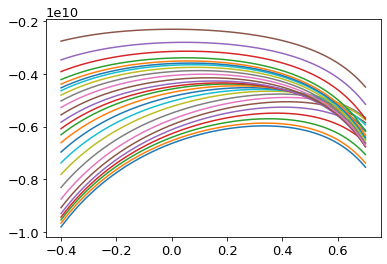

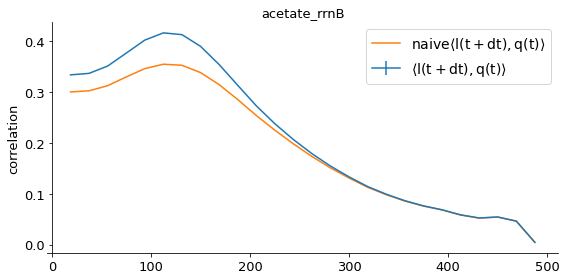

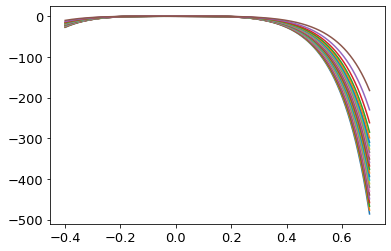

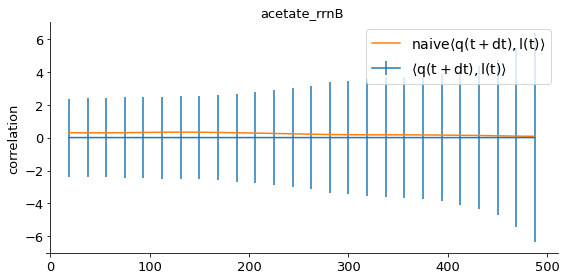

In [198]:


for filename, dt, corr in zip(filenames, dts, corrs):
    data_set = filename.split("/")[-1].split("_")[0] + '_' + filename.split("/")[-1].split("_")[1]
    plot_file = os.path.join( "/Users/bjoern/mother_machine/experimental_data/inference_output_summary/plots/", 
                            data_set + "_correlation_{:s}{:s}.pdf")
    print(plot_file)

    # tree_correlation(corr, "l(t+dt)", "l(t)", plot_file=plot_file, title=data_set, param_dict=read_final_params(filename))
    # tree_correlation(corr, "q(t+dt)", "q(t)", plot_file=plot_file, title=data_set, param_dict=read_final_params(filename))

    tree_correlation(corr, "l(t+dt)", "q(t)", title=data_set)
    tree_correlation(corr, "q(t+dt)", "l(t)", title=data_set)
    break

In [199]:
covs = []

for i in range(3):
    base = 'ac_single_lin_gamma_q_n500_sizer'
    file = ('../data_3.0/'+base+'/'+base+'_{:d}/'+base+'_{:d}_out/'+base+'_{:d}_f012345678910_b_joints.csv').format(i,i,i)
    print(file)
    covs.append(file2correlation_function(file, np.arange(3,500,3), 0.3)
    


SyntaxError: unexpected EOF while parsing (<ipython-input-199-26ef22458b82>, line 8)